In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

import dataset
import dataset_misc1d
import dataset_misc2d
from backprop import backprop, gp, utils, library
import space

SAMPLE_SIZE = 200
NOISE = 0.03

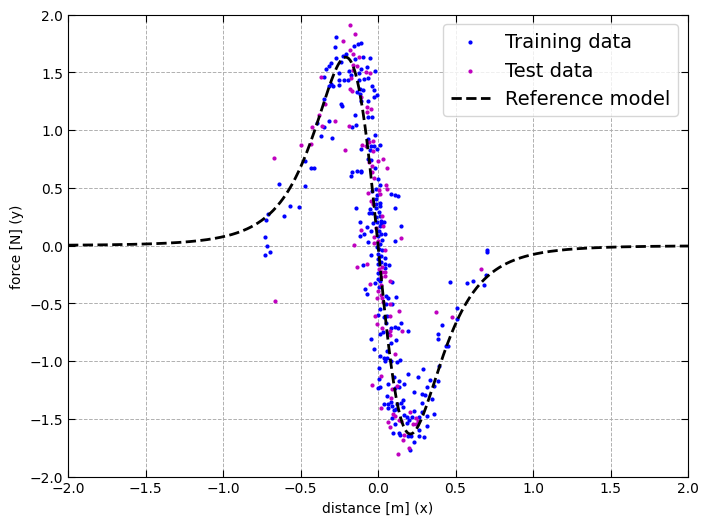

In [2]:
S = dataset_misc1d.MagmanDatasetScaled()
#S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
S.load('../data/magman.csv')
S.split()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)
S_know  = S.knowledge.synth_dataset()

X_mesh = S.spsampler.meshspace(S.xl, S.xu, 100)
meshspace = space.MeshSpace(X_mesh, S_train.X)

In [3]:
#from backprop import project
#project.project_semantic(S_train.y, S_train, S.knowledge)
#S_train.get_plotter().plot(width=8, height=6)

In [ ]:
#lib = library.Library(2000, 2, S_train)
lib = library.ConstrainedLibrary(2000, 3, S_train, X_mesh)

In [ ]:
import time

backprop_node = backprop.ConstantSyntaxTree(2.0)
stree = backprop.BinaryOperatorSyntaxTree('/',
        backprop.BinaryOperatorSyntaxTree('*',
            backprop.ConstantSyntaxTree(0.05),
            backprop.VariableSyntaxTree(),
        ),
        backprop_node
    )

stree.set_parent()
y = stree(S_train.X)  # needed for 'pull_output'.
pulled_y, _ = backprop_node.pull_output(S_train.y)

S_backprop = dataset.NumpyDataset(S)
S_backprop.X = S_train.X
S_backprop.y = pulled_y

lib_nodes = lib.multiquery(pulled_y, k=200)
lib_node = lib_nodes[0][1]
#lib_node = lib.query(pulled_y)
lib_node_dist = library.compute_distance(lib_node(S_backprop.X), pulled_y)
lib_node_mse  = library.compute_mse     (lib_node(S_backprop.X), pulled_y)
lib_node.clear_output()

print(lib_node)
print(f"Distance: {lib_node_dist}")
print(f"MSE: {lib_node_mse}")
S_backprop.get_plotter().plot(width=8, height=6, model=lib_node)

# backprop knowledge.
#print(S_know.y)
stree[(S_know.X, ())]  # needed for 'pull_know'.
k_pulled, noroot_pulled = backprop_node.pull_know(S_know.y)
print(k_pulled)
print(noroot_pulled)

# project.
"""pos_idx = (k_pulled[meshspace.X_data_map] > 0.0)[meshspace.X_data_map]
neg_idx = (k_pulled[meshspace.X_data_map] < 0.0)[meshspace.X_data_map]
S_backprop.y[pos_idx] = np.maximum(S_backprop.y[pos_idx], 1e-3)
S_backprop.y[neg_idx] = np.minimum(S_backprop.y[neg_idx], 1e-3)"""

# remove outliers.
#S_backprop.remove_outliers()

K_pulled = (k_pulled.tobytes(), noroot_pulled)

#y_0 = (-0.05*S_train.X[:,0]) / pulled_y
#y_h = (-0.05*S_train.X[:,0]) / (pulled_y + 1e-3)
#w = np.absolute(y_h - y_0) / 1e-3

start_time = time.time()
lib_node = lib.cquery_brute(pulled_y, K_pulled, S_train=S_train)
#lib_node = lib.cquery_stoch(pulled_y, K_pulled)
end_time = time.time()
print(f"Elapsed: {end_time-start_time}")
#lib_node = backprop.BinaryOperatorSyntaxTree('+',
#    lib_node, backprop.ConstantSyntaxTree(1e-2))
print(lib_node)

S_backprop.remove_outliers()
S_backprop.get_plotter().plot(width=8, height=6, model=lib_node)

((0.05 * x0) / (-1.00 * cube(((x0 * x0) + cube(0.55)))))


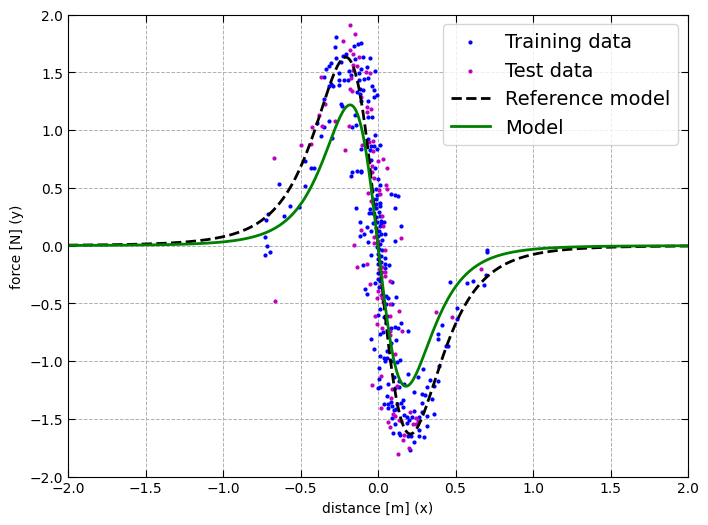

In [6]:
offspring = gp.replace_subtree(stree, backprop_node, lib_node)
#lib_node.parent.invalidate_output()
offspring.clear_output()
print(offspring)
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=offspring, zoomout=1)

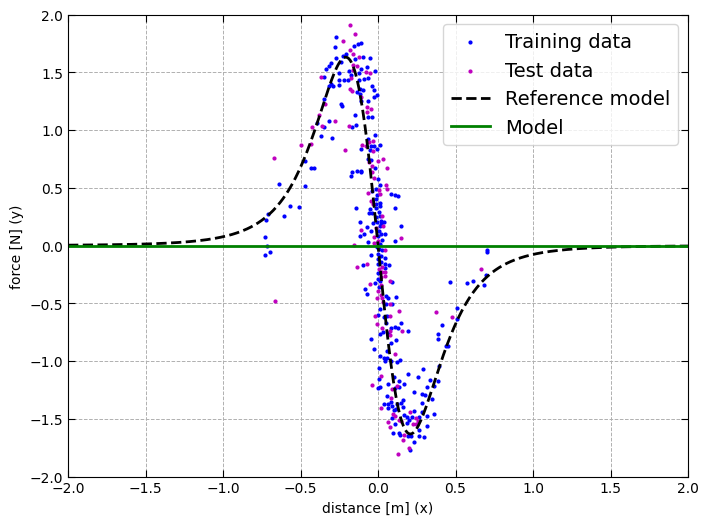

In [7]:
from scipy.optimize import least_squares

offspring.clear_output()
offspring.set_parent()

def resid_func(coeffs):
    global lib_node, offspring, S_train
    lib_node.set_coeffs(coeffs)
    lib_node.clear_output()
    lib_node.invalidate_output()
    offspring.clear_output()
    return offspring(S_train.X) - S_train.y

coeffs0 = []
lib_node.get_coeffs(coeffs0)
new_coeffs = least_squares(resid_func, coeffs0, method='lm').x

lib_node.set_coeffs(new_coeffs)
offspring.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=offspring, zoomout=1)